# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [83]:
# Code source: Filippo Orazi 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")

random_state = 42 # this will be used to guarantee the repeatability of the experiment

## Dataset preparation

### Load the dataset from a `.csv` file
This cell allows full compatibility between execution in Google Colab and in local


In [52]:
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()


The file must be available in the same directory, or uploaded in the Colab environment in the execution of the previous cell


Set the date column as index

In [53]:
df = pd.read_csv('./power_demand_vs_temperature.csv', index_col=0)
df.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [54]:
df.describe()

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [55]:
print(f"The dataframe has {df.isnull().sum().sum()} invalid rows")

The dataframe has 0 invalid rows


### Create X and y 

In [56]:
X = df.drop(columns=['demand'], axis=1)
y = df['demand']

print(f"X has shape {X.shape}")
print(f"Y has shape {y.shape}")

X has shape (1096, 1)
Y has shape (1096,)


### Plot the distribution



Text(0, 0.5, 'Demand')

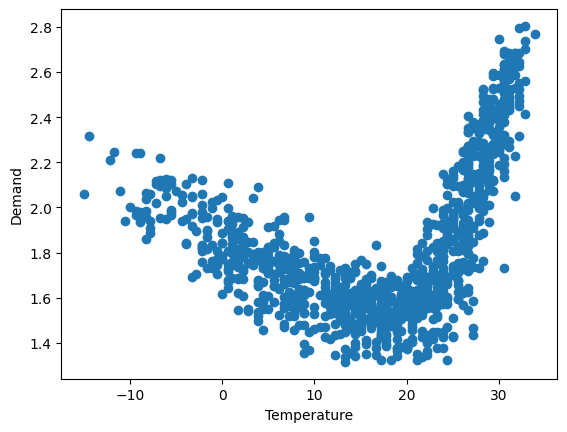

In [57]:
fig, ax = plt.subplots()

ax.scatter(data=df, x='temp', y='demand')
plt.xlabel('Temperature')
plt.ylabel('Demand')

### Divide the dataset in train and test splits

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

print(f"Training set and test set have {X_train.shape[0]} and {X_test.shape[0]} elements respectively")

Training set and test set have 767 and 329 elements respectively


### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [59]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def f_test(y_true, y_pred, n_var, n_obs, sn=.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE 
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic 
    return F, p

def print_eval(X, y, model):
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(pred, y), F, p

## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [124]:
pr_model = LinearRegression()
pr_model.fit(X_train.temp.values.reshape(-1,1), y_train)
no_pol_metrics = print_eval(X_test, y_test, pr_model)

 Mean squared error: 	0.10165
 r2 score: 		0.16809
 f-statistic: 		44.576
 p-value: 		1.0503e-10


#### Visualize the prediction of the model 

Text(0, 0.5, 'Demand')

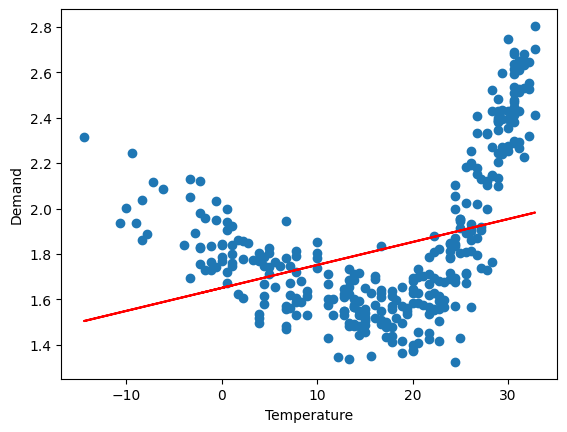

In [125]:
# plot the regression line
fig, ax = plt.subplots()

ax.scatter(X_test.temp, y_test)
ax.plot(X_test.temp, pr_model.predict(X_test.temp.values.reshape(-1,1)), color='red')
plt.xlabel('Temperature')
plt.ylabel('Demand')

## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

In [126]:
p_regression_model = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = p_regression_model.fit_transform(X_train.values)
poly_regression = LinearRegression()
poly_regression.fit(X_train_poly, y_train)

LinearRegression()

In [127]:
two_pol_metrics = print_eval(p_regression_model.transform(X_test), y_test, poly_regression)

 Mean squared error: 	0.033456
 r2 score: 		0.72619
 f-statistic: 		384.89
 p-value: 		1.1102e-16


Text(0, 0.5, 'Demand')

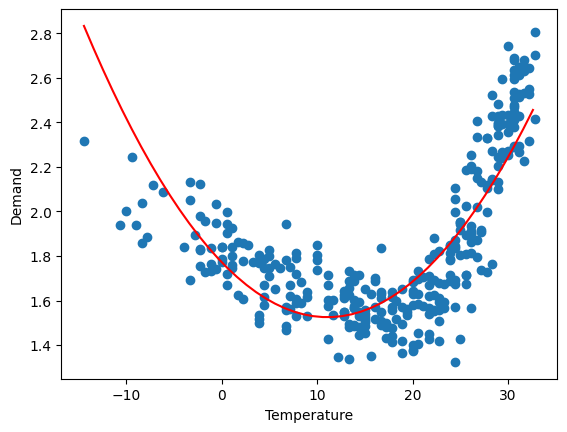

In [128]:
fig, ax = plt.subplots()

reg_predicition = poly_regression.predict(p_regression_model.transform(np.arange(min(X_test.temp), max(X_test.temp)).reshape(-1,1)))

ax.scatter(X_test.temp, y_test)
ax.plot(np.arange(min(X_test.temp), max(X_test.temp)), reg_predicition, color='red')
plt.xlabel('Temperature')
plt.ylabel('Demand')

## Third experiment

#### Polynomial degree = 3

In [129]:
three_polynomial_regression = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = three_polynomial_regression.fit_transform(X_train.values)
three_poly_regression = LinearRegression()
three_poly_regression.fit(X_train_poly, y_train)

LinearRegression()

In [130]:
three_pol_metrics = print_eval(three_polynomial_regression.transform(X_test), y_test, three_poly_regression)

 Mean squared error: 	0.021749
 r2 score: 		0.822
 f-statistic: 		502.32
 p-value: 		1.1102e-16


Text(0, 0.5, 'Demand')

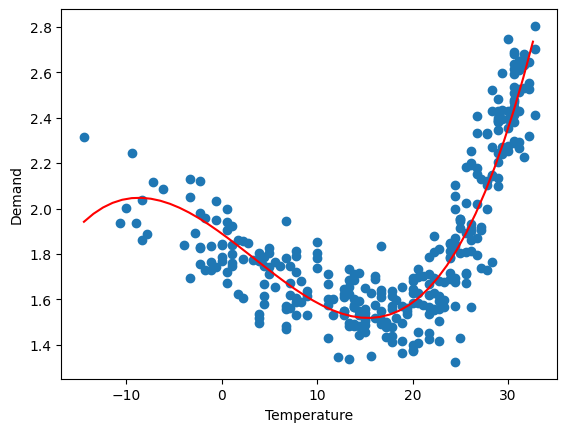

In [131]:
fig, ax = plt.subplots()

reg_predicition = three_poly_regression.predict(three_polynomial_regression.transform(np.arange(min(X_test.temp), max(X_test.temp)).reshape(-1,1)))
ax.scatter(X_test.temp, y_test)
ax.plot(np.arange(min(X_test.temp), max(X_test.temp)), reg_predicition, color='red')
plt.xlabel('Temperature')
plt.ylabel('Demand')


## Fourth experiment
### Polynomial degree = 4

In [132]:
four_polynomial_regression = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = four_polynomial_regression.fit_transform(X_train.values)
four_poly_regression = LinearRegression()
four_poly_regression.fit(X_train_poly, y_train)

LinearRegression()

In [133]:
four_pol_metrics = print_eval(four_polynomial_regression.transform(X_test), y_test, four_poly_regression)

 Mean squared error: 	0.021334
 r2 score: 		0.8254
 f-statistic: 		390.05
 p-value: 		1.1102e-16


Text(0, 0.5, 'Demand')

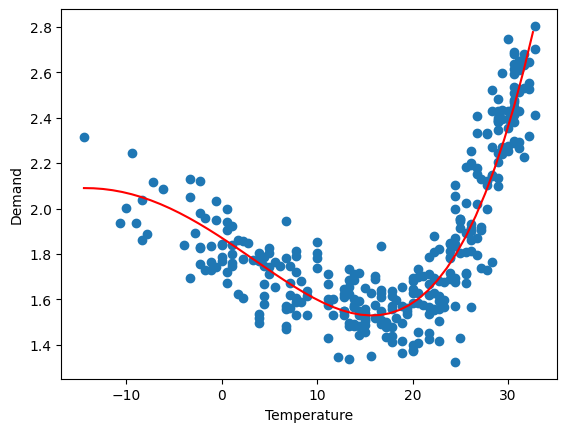

In [123]:
fig, ax = plt.subplots()

reg_predicition = four_poly_regression.predict(four_polynomial_regression.transform(np.arange(min(X_test.temp), max(X_test.temp)).reshape(-1,1)))
ax.scatter(X_test.temp, y_test)
ax.plot(np.arange(min(X_test.temp), max(X_test.temp)), reg_predicition, color='red')
plt.xlabel('Temperature')
plt.ylabel('Demand')

## Compare the performance of the four models

In [135]:
metrics_df = pd.DataFrame([no_pol_metrics, two_pol_metrics, three_pol_metrics, four_pol_metrics], columns=['linear', 'polynomial d = 2', 'polynomial d = 3', 'polynomial d = 4'], index=['rmse', 'r2', 'f-statistic', 'p-value'])
metrics_df

,linear,polynomial d = 2,polynomial d = 3,polynomial d = 4
rmse,0.101651,-7.031040,44.576377,1.050272e-10
r2,0.033456,0.575632,384.886508,1.110223e-16
f-statistic,0.021749,0.784332,502.318288,1.110223e-16
p-value,0.021334,0.792332,390.045434,1.110223e-16
